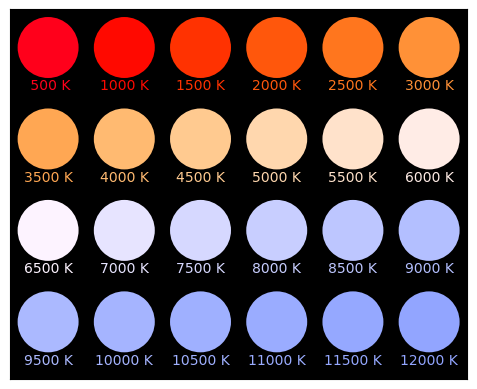

In [1]:
import numpy as np
from scipy.constants import h, c, k
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

from colour_system import *
cs = cs_hdtv

def planck(lam, T):
    """ Returns the spectral radiance of a black body at temperature T.

    Returns the spectral radiance, B(lam, T), in W.sr-1.m-2 of a black body
    at temperature T (in K) at a wavelength lam (in nm), using Planck's law.

    """

    lam_m = lam / 1.e9
    fac = h*c/lam_m/k/T
    B = 2*h*c**2/lam_m**5 / (np.exp(fac) - 1)
    return B

fig, ax = plt.subplots()

# The grid of visible wavelengths corresponding to the grid of colour-matching
# functions used by the ColourSystem instance.
lam = np.arange(380., 781., 5)

for i in range(24):
    # T = 500 to 12000 K
    T = 500*i + 500

    # Calculate the black body spectrum and the HTML hex RGB colour string
    # it looks like
    spec = planck(lam, T)
    html_rgb = cs.spec_to_rgb(spec, out_fmt='html')

    # Place and label a circle with the colour of a black body at temperature T
    x, y = i % 6, -(i // 6)
    circle = Circle(xy=(x, y*1.2), radius=0.4, fc=html_rgb)
    ax.add_patch(circle)
    ax.annotate('{:4d} K'.format(T), xy=(x, y*1.2-0.5), va='center',
                ha='center', color=html_rgb)

# Set the limits and background colour; remove the ticks
ax.set_xlim(-0.5,5.5)
ax.set_ylim(-4.35, 0.5)
ax.set_xticks([])
ax.set_yticks([])
ax.set_facecolor('k')
# Make sure our circles are circular!
ax.set_aspect("equal")
plt.show()

In [2]:
# import data for one spectrum
spec_fine = np.genfromtxt("./spectra/redrednofiber1.txt")
spec_bkg = np.genfromtxt("./spectra/nightzenith3.txt")

# truncate
spec_fine = spec_fine[np.logical_and(spec_fine[:,0]>=380,spec_fine[:,0]<=780)]
spec_bkg = spec_bkg[np.logical_and(spec_bkg[:,0]>=380,spec_bkg[:,0]<=780)]

#normalize w.r.t. area
area_fine = np.sum(spec_fine[:,1][:-1]*np.diff(spec_fine[:,0][:]))
area_bkg = np.sum(spec_bkg[:,1][:-1]*np.diff(spec_bkg[:,0]))

spec_norm = spec_fine[:,1]/area_fine
bkg_norm = spec_bkg[:,1]/area_bkg

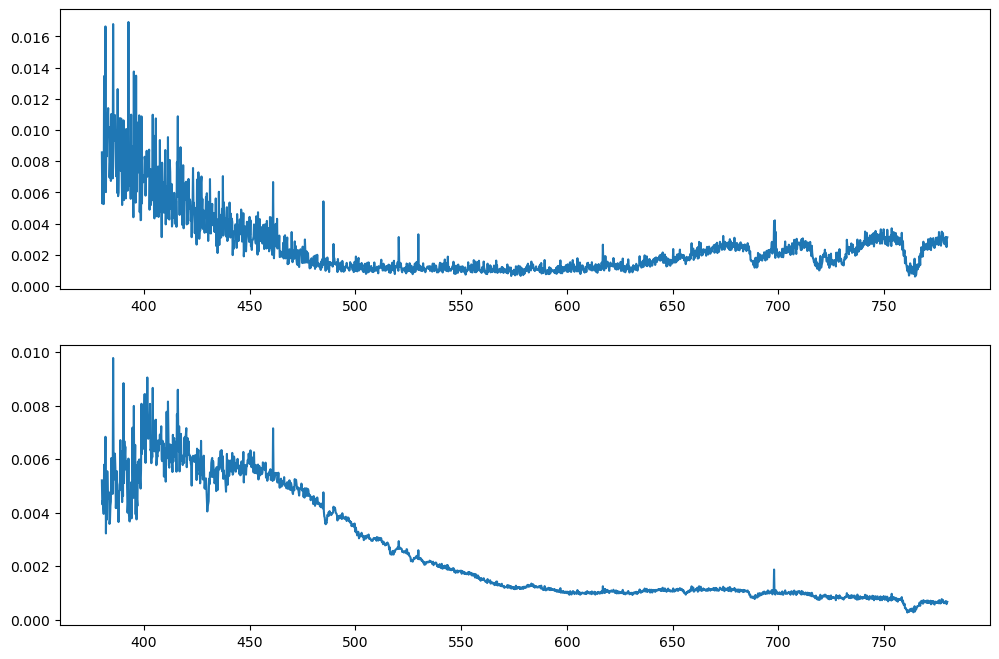

In [3]:
fig,ax = plt.subplots(2,1, figsize=(12,8))
ax[0].plot(spec_fine[:,0],spec_norm)
ax[1].plot(spec_bkg[:,0],bkg_norm)

In [4]:
# wavelengths defined in the color matching function
lam = np.arange(380., 781., 5)

# re-bin to match the color matching function
indices = np.digitize(spec_fine[:,0], lam)

mean_spec = np.zeros(len(lam))
for i in range(1,len(lam)):
    cond = np.where(indices==i)
    mean_spec[i-1] = max(np.nanmean(spec_norm[cond]-bkg_norm[cond]),0)

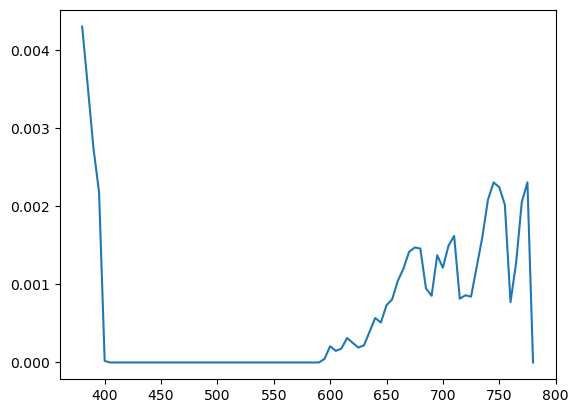

In [5]:
plt.plot(lam,mean_spec)

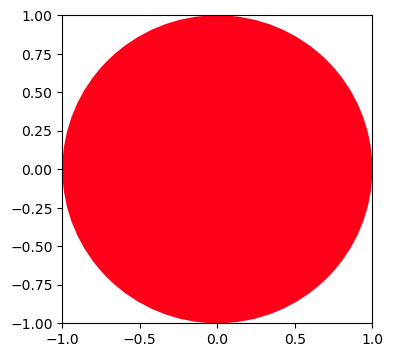

In [6]:
html_rgb = cs.spec_to_rgb(mean_spec, out_fmt='html')

fig,ax = plt.subplots(figsize=(4,4))

circle = Circle(xy=(0,0), radius=1, fc=html_rgb)
ax.set_xlim(-1,1)
ax.set_ylim(-1,1)
ax.add_patch(circle)

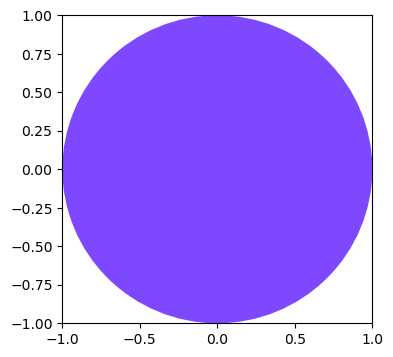

In [7]:
# wavelengths defined in the color matching function
lam = np.arange(380., 781., 5)

# re-bin to match the color matching function
indices = np.digitize(spec_fine[:,0], lam)

mean_spec = np.zeros(len(lam))
for i in range(1,len(lam)):
    cond = np.where(indices==i)
    mean_spec[i-1] = np.nanmean(spec_norm[cond])
    
html_rgb = cs.spec_to_rgb(mean_spec, out_fmt='html')

fig,ax = plt.subplots(figsize=(4,4))

circle = Circle(xy=(0,0), radius=1, fc=html_rgb)
ax.set_xlim(-1,1)
ax.set_ylim(-1,1)
ax.add_patch(circle)

In [8]:
def normalize_spectrum(file_path):
    
    #load in spectrum data from txt
    spec = np.genfromtxt(file_path)
    
    #truncate to visible range
    spec_trunc = spec[np.logical_and(spec[:,0]>=380,spec[:,0]<=780)]
    
    #normalize the spectrum with respect to area
    area = np.sum(spec_trunc[:,1][:-1]*np.diff(spec_trunc[:,0][:]))
    
    return spec_trunc[:,0],spec_trunc[:,1]/area

def rebin_spectrum(axis, spec, bins, bkg=None):
    
    #sort spectrum into cmf bins
    ind = np.digitize(axis,bins)
    
    mean_spec = np.zeros(len(bins))
    
    #if background is provided, subtract background
    if bkg:
        for i in range(1,len(bins)):
            cond = np.where(ind==i)
            mean_spec[i-1] = np.nanmean(spec[cond]-bkg[cond])
    
    #otherwise, just take the mean in each bin
    else:
        for i in range(1,len(bins)):
            cond = np.where(ind==i)
            mean_spec[i-1] = np.nanmean(spec[cond])
    
    return mean_spec

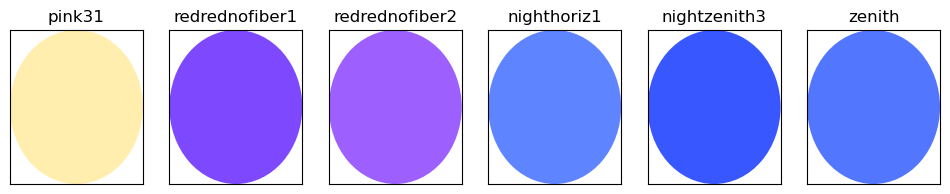

In [9]:
specs = ['pink31','redrednofiber1','redrednofiber2','nighthoriz1','nightzenith3','zenith']

fig,ax = plt.subplots(1,6,figsize=(12,2))

lam = np.arange(380.,781.,5)

for i in range(6):
    spec_name = './spectra/'+specs[i]+'.txt'
    
    axis, spec_norm = normalize_spectrum(spec_name)
    
    spec_mean = rebin_spectrum(axis,spec_norm,lam)
    
    html_rgb = cs.spec_to_rgb(spec_mean, out_fmt='html')
    
    circle = Circle(xy=(0,0), radius=1, fc=html_rgb)
    
    ax[i].set_xlim(-1,1)
    ax[i].set_ylim(-1,1)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].set_title(specs[i])
    
    ax[i].add_patch(circle)

# code for generating plank color from temperature

In [10]:
import numpy as np
from scipy.constants import h, c, k
from colour_system import *
cs = cs_hdtv

def planck(lam, T):
    """ Returns the spectral radiance of a black body at temperature T.

    Returns the spectral radiance, B(lam, T), in W.sr-1.m-2 of a black body
    at temperature T (in K) at a wavelength lam (in nm), using Planck's law.

    """

    lam_m = lam / 1.e9
    fac = h*c/lam_m/k/T
    B = 2*h*c**2/lam_m**5 / (np.exp(fac) - 1)
    return B

# The grid of visible wavelengths corresponding to the grid of colour-matching
# functions used by the ColourSystem instance.
lam = np.arange(380., 781., 5)

def blackbody_color(T):
    spec = planck(lam, T)
    rgb = cs.spec_to_rgb(spec)
    return np.round(rgb*255)

print(blackbody_color(3500))

[255. 168.  83.]


# Code to generate "blue sky" color for specific stars/binaries

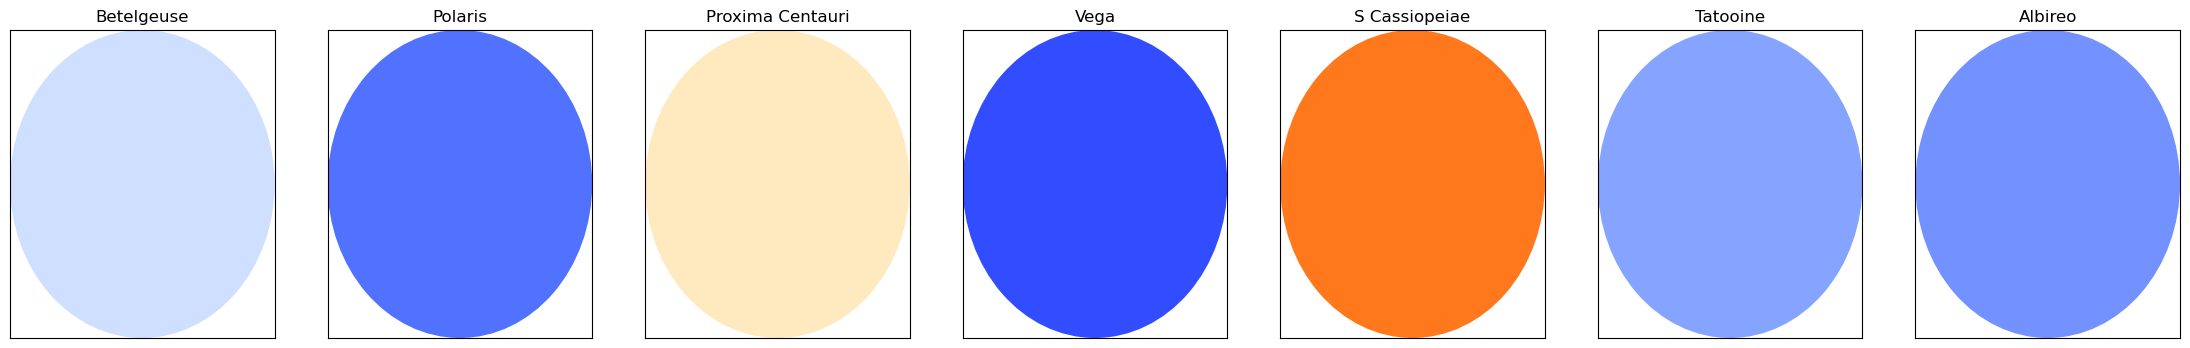

In [11]:
stars = ['Betelgeuse', 'Polaris', 'Proxima Centauri', 'Vega', 'S Cassiopeiae']
binary_stars = ['Tatooine', 'Albireo']

single_temps = [3600, 6015, 2992, 9602, 1800]
binary_temps = [[4450,3311], [4383,13200]]
binary_rel_r = [[0.8916254518,0.1083745482],[0.9982579568,0.001742043236]]

single_specs = []
binary_specs = []

for i in range(len(stars)):
    single_specs.append(planck(lam,single_temps[i])/lam**4)

for i in range(len(binary_stars)):
    binary_specs.append((binary_rel_r[i][0]*planck(lam,binary_temps[i][0])+binary_rel_r[i][1]*planck(lam,binary_temps[i][1]))/lam**4)

single_specs = np.array(single_specs)
binary_specs = np.array(binary_specs)

fig,ax = plt.subplots(1,len(stars)+len(binary_stars),figsize=((len(stars)+len(binary_stars))*4,4))

for i in range(len(stars)):
    html_rgb = cs.spec_to_rgb(single_specs[i], out_fmt='html')
    
    circle = Circle(xy=(0,0), radius=1, fc=html_rgb)
    
    ax[i].set_xlim(-1,1)
    ax[i].set_ylim(-1,1)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].set_title(stars[i])
    
    ax[i].add_patch(circle)

for i in range(len(binary_stars)):
    html_rgb = cs.spec_to_rgb(binary_specs[i], out_fmt='html')
    
    circle = Circle(xy=(0,0), radius=1, fc=html_rgb)
    
    ax[i+len(stars)].set_xlim(-1,1)
    ax[i+len(stars)].set_ylim(-1,1)
    ax[i+len(stars)].set_xticks([])
    ax[i+len(stars)].set_yticks([])
    ax[i+len(stars)].set_title(binary_stars[i])
    
    ax[i+len(stars)].add_patch(circle)

In [12]:
star_names = ['Betelgeuse', 'Polaris', 'Proxima Centauri', 'Vega', 'S Cassiopeiae', 'Tatooine', 'Albireo']

rgb_vals = []
for spec in single_specs:
    rgb = cs.spec_to_rgb(spec)
    rgb_vals.append(np.round(rgb*255))

for spec in binary_specs:
    rgb = cs.spec_to_rgb(spec)
    rgb_vals.append(np.round(rgb*255))

rgb_vals = np.array(rgb_vals)

np.savetxt('hardcoded_stars.dat',rgb_vals)